# Global Variable (Edit Before you Run on your own)

In [16]:
EPOCHS_SIZE = 32 #Adjusted for trial first
BATCH_SIZE = 128
MODEL_SAVE_NAME = "digit_symbol_model_v2_with_30epochs" #change this so that u dont overwrite saved model
LOADED_MODEL_NAME = "" #Edit this one below
training_class_labels = ['(',')','+','-','0','1','2','3','4','5','6','7','8','9','=','div','times']
class_labels_dict = {'(': 0,')': 1,'+': 2,'-': 3,'0': 4,'1': 5,'2': 6,'3': 7,'4': 8,'5': 9,'6': 10,'7': 11,'8': 12,'9': 13,'=': 14,'div': 15,'times': 16}

# Pre requisites that you need to install before use

#Just Run Once
!pip install tensorflow
!pip install scikit-learn
!pip install keras
!pip install keras-tuner
!pip install matplotlib
!pip install opencv-python
!pip install scipy

## Imports

In [1]:
import os
import glob
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import seaborn as sns
from keras import metrics
from tensorflow.keras.layers import Dropout, BatchNormalization

Using TensorFlow backend


# Training

### 1. Function to Load The Images from Folder

In [4]:
def pre_processing_from_dir(dataset_dir, class_labels_dict, training=False):
    # Initialize lists to store images and labels
    images = []
    labels = []
    class_labels = []

    # Get a list of all subdirectories (each subdirectory represents a class)
    class_directories = os.listdir(dataset_dir)

    # Iterate through each subdirectory (class directory)
    for class_directory in class_directories:
        class_label = class_directory  # Use the directory name as the class label
        
        class_labels.append(class_label)
        class_path = os.path.join(dataset_dir, class_directory)

        # Get a list of image files in the class directory
        image_files = glob.glob(os.path.join(class_path, "*.jpg"))  # You may need to adjust the file extension

        # print(image_files)

        # Iterate through image files in the class directory
        for image_file in image_files:
            # Load and preprocess the image
            image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (28, 28))
            image = image / 255.0  # Normalize pixel values

            # plt.imshow(image, cmap=plt.cm.binary)

            # Append the preprocessed image and its label to the lists
            images.append(image)
            labels.append(class_label)

    if training:

        data = list(zip(images, labels))

        # Shuffle the combined data
        np.random.shuffle(data)

        # shuffle the training images
        shuffled_images, shuffled_labels = zip(*data)

        images = np.array(shuffled_images)

        label_encoder = LabelEncoder()

        # Encode class labels using LabelEncoder
        labels = label_encoder.fit_transform(shuffled_labels)

        for i in range(len(class_labels)):
            class_labels_dict[class_labels[i]] = i

        labels = np.array(labels, dtype="int64")

        # comment the below 2 lines if doing label-encoding
        # One-hot encode labels (need to do one code in order to fit into the model)
        num_classes = len(class_labels)
        labels = to_categorical(labels, num_classes=num_classes)

        return images, labels, class_labels, class_labels_dict

    else:
       
        # Convert lists to NumPy arrays
        images = np.array(images)

        # label-encoding done on test data should correspond to the ones in training data
        # this is to account for times when test data is lesser than training data

        for i in range(len(labels)):
            labels[i] = class_labels_dict[labels[i]]

        labels = np.array(labels, dtype="int64")

        # comment the below 2 lines if doing label-encoding
        # One-hot encode labels (need to do one code in order to fit into the model)
        num_classes = len(class_labels_dict)
        labels = to_categorical(labels, num_classes=num_classes)

        return images, labels, class_labels

In [7]:
images, labels, training_class_labels, class_labels_dict = pre_processing_from_dir("final_82/train_images", {}, True)

### 2. Data Augmentation Function for Training Data 
- random rotation
- random noise

In [8]:
def data_augmentation(image):

    ##############################################################
    # Rotating images to mimic slanted handwriting

    # Convert the image to a NumPy array (assuming it's in the range [0, 1])
    image = (image * 255).astype(np.uint8)

    # Calculate the image center
    center = tuple(np.array(image.shape[1::-1]) / 2)

    rotation_angle = random.uniform(-30, 30)

    # Create a rotation matrix and apply the rotation
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR, borderValue=(255, 255, 255))

    # Convert back to the range [0, 1]
    rotated_image = rotated_image.astype(np.float32) / 255.0

    ##############################################################
    # Adding random noise to mimic low quality images

    max_noise_level = random.uniform(0, 0.1)
    noise = tf.random.normal(shape=tf.shape(rotated_image), stddev=max_noise_level)
    
    return tf.clip_by_value(rotated_image + noise, 0.0, 1.0)


### 3. Function for Defining The Model

In [6]:
def math_model(images, labels, num_classes, model_name):

    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    # perform data augmentation on X_train
    X_train = np.array([data_augmentation(image) for image in X_train])

    # Define your CNN model for multi-class classification

    input_shape = (28,28,1) # decision point: what size are our images fixed at
    layer1_size = 32 # number of filters in the convolutional layer
    layer2_size = 64
    layer3_size = 128
    layer_shape = (3,3) # size of the filter

    pool_shape = (2,2) # size of the pooling layer
    fully_connected_layer_size = 128 # number of neurons in the fully connected layer


    model = Sequential([
        layers.Conv2D(layer1_size, layer_shape, activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_shape),
        layers.Conv2D(layer2_size, layer_shape, activation='relu'),
        layers.MaxPooling2D(pool_shape),
        layers.Conv2D(layer3_size, layer_shape, activation='relu'),
        layers.MaxPooling2D(pool_shape),
        layers.Flatten(),
        layers.Dense(fully_connected_layer_size, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model_metrics = ['accuracy', metrics.Recall(name = "Recall"), metrics.Precision(name = "Precision")]

    # Compile the model
    # for one-hot encoding
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=model_metrics)

    # uncomment this if using label-encoding, & comment the one above
    # model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=model_metrics)

    # Fit model. (Batch size either 32, 64, 128. 1000 epochs as we expect training to stop before that.
    history = model.fit(X_train, y_train, batch_size=BATCH_SIZE,
                    epochs=EPOCHS_SIZE, validation_data=(X_test, y_test))

    # Save the trained model for later use
    model.save(f"{model_name}.keras")

    # return history to see whether model is overfitting or underfitting
    return f"{model_name}.keras", history, X_test, y_test

### 4. Function for Evaluating Training Model
- Confusion Matrix, 
- Classification Report, 
- Number of Correct, Wrong and % Match

In [2]:
def math_reports(model, X_test, y_test, test_class_labels, train_class_labels):

    # Load the saved model
    loaded_model = tf.keras.saving.load_model(model)

    predicted_y = loaded_model.predict(X_test)

    # Convert one-hot encoded labels back to integer labels
    y_test_labels = y_test

    # comment this if label-encoding was used
    y_test_labels = np.argmax(y_test_labels, axis=1)

    predicted_labels = np.argmax(predicted_y, axis=1)

    confusion = confusion_matrix(y_test_labels, predicted_labels)

    cf_report = classification_report(y_test_labels, predicted_labels, labels=np.unique(y_test_labels), target_names=test_class_labels)

    # Initialize dictionaries to store correct and total counts for each class
    correct_instances_per_class = {}
    total_instances_per_class = {}
    report = ""
    predicted_report = ""

    # Iterate through predictions and true labels to calculate correct and total instances
    for i in range(predicted_labels.size):
        predicted = train_class_labels[predicted_labels[i]]
        test_label = train_class_labels[y_test_labels[i]]

        result = "wrong"

        if (predicted == test_label):
            result = "correct"

        predicted_report += f"Predicted: {predicted}, Actual: {test_label}, Result: {result}\n"

        if test_label not in correct_instances_per_class:
            correct_instances_per_class[test_label] = 0
            total_instances_per_class[test_label] = 0

        total_instances_per_class[test_label] += 1

        if predicted == test_label:
            correct_instances_per_class[test_label] += 1

    import operator

    sorted_correct = dict(sorted(correct_instances_per_class.items(), key=operator.itemgetter(0)))

    # Print the summary of correct/total for each class
    for label in sorted_correct:
        correct_count = sorted_correct[label]
        total_count = total_instances_per_class[label]
        report += f"Class {label}: Correct {correct_count}/{total_count} | Wrong: {total_count - correct_count} | %Match: {round((correct_count/total_count) * 100,2)}\n"

    return confusion, cf_report, report, predicted_report, predicted_labels

# Running model on Training Data (Digits & Symbols Images only (17 classes))

In [17]:
model, history, X_test, y_test = math_model(images, labels, len(training_class_labels), MODEL_SAVE_NAME)

Epoch 1/32
1121/1121 [==============================] - 44s 39ms/step - loss: 0.9259 - accuracy: 0.7164 - Recall: 0.6123 - Precision: 0.8691 - val_loss: 0.3473 - val_accuracy: 0.8985 - val_Recall: 0.8825 - val_Precision: 0.9190
Epoch 2/32
1121/1121 [==============================] - 40s 36ms/step - loss: 0.3916 - accuracy: 0.8805 - Recall: 0.8549 - Precision: 0.9093 - val_loss: 0.2472 - val_accuracy: 0.9281 - val_Recall: 0.9200 - val_Precision: 0.9384
Epoch 3/32
1121/1121 [==============================] - 61s 54ms/step - loss: 0.3079 - accuracy: 0.9052 - Recall: 0.8892 - Precision: 0.9244 - val_loss: 0.2328 - val_accuracy: 0.9312 - val_Recall: 0.9246 - val_Precision: 0.9395
Epoch 4/32
1121/1121 [==============================] - 87s 78ms/step - loss: 0.2682 - accuracy: 0.9185 - Recall: 0.9052 - Precision: 0.9329 - val_loss: 0.2109 - val_accuracy: 0.9380 - val_Recall: 0.9327 - val_Precision: 0.9461
Epoch 5/32
1121/1121 [==============================] - 44s 39ms/step - loss: 0.2393 - a

### Check for under/overfitting & deciding on epoch

1121/1121 [==============================] - 20s 17ms/step - loss: 0.1620 - accuracy: 0.9655 - Recall: 0.9651 - Precision: 0.9663
30 epochs
0.9654691219329834
0.1620192974805832


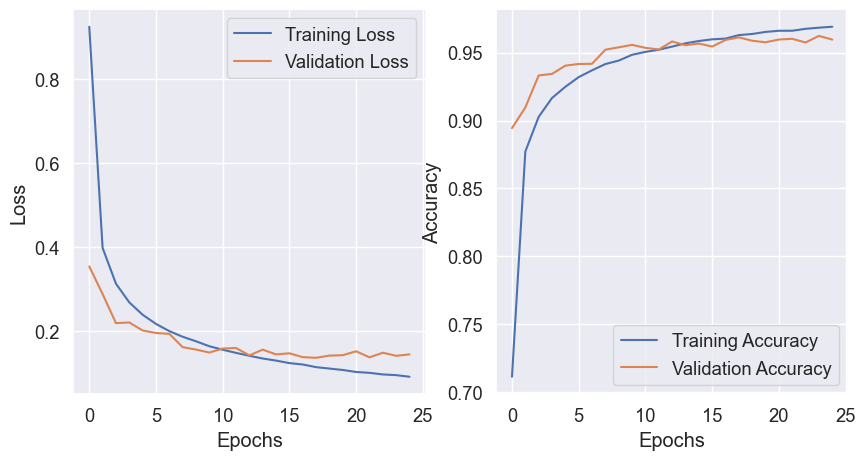

In [70]:
model = "digit_symbol_model_v2_with_30epochs.keras"
loaded_model = tf.keras.saving.load_model(model)

loss, accuracy, recall, precision = loaded_model.evaluate(X_test, y_test)
print("30 epochs")
print(accuracy)
print(loss)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Reports (Training data)

In [ ]:
model = "digit_symbol_model_v2_with_30epochs.keras"

In [11]:
confusion, cf_report, report, predicted_report, predicted_labels = math_reports(model, X_test, y_test, training_class_labels, training_class_labels)

In [ ]:
print("Confusion Matrix")
print(confusion)

In [ ]:
print("Classification Report")
print(cf_report)

In [ ]:
print("Confusion Matrix Report")
print(report)

In [ ]:
print("Predicted vs Actual")
print(predicted_report)

# Running Model with Unseen Test Data (Digits & Symbols Images only (17 classes))

In [8]:
#load test_images
images_test, labels_test, test_class_labels = pre_processing_from_dir("final_82/test_images", class_labels_dict)

In [9]:
# change the model if needed
model = "digit_symbol_model_v2_with_30epochs.keras"

### Reports (Unseen Test Data (17 classes))

In [10]:
#Predict using loaded model
confusion_test, cf_report_test, report_test, predicted_report_test, predicted_labels_test = math_reports(model, images_test, labels_test, test_class_labels, training_class_labels)

623/623 [==============================] - 5s 7ms/step


In [59]:
print("Classification Report Test")
print(cf_report_test)

Classification Report Test
              precision    recall  f1-score   support

           (       0.88      0.97      0.92      1429
           )       0.97      0.93      0.95      1435
           +       0.98      0.98      0.98      2511
           -       0.99      1.00      0.99      3400
           0       0.98      0.96      0.97       692
           1       0.95      0.88      0.91      2652
           2       0.95      0.97      0.96      2615
           3       0.99      0.98      0.98      1091
           4       0.95      0.96      0.96       740
           5       0.97      0.96      0.96       355
           6       0.95      0.95      0.95       312
           7       0.85      0.95      0.90       291
           8       0.92      0.94      0.93       307
           9       0.96      0.98      0.97       373
           =       0.97      0.99      0.98      1311
         div       0.92      0.91      0.91        87
       times       0.98      0.93      0.96       326


In [45]:
print("Confusion Matrix Test")
print(confusion_test)

Confusion Matrix Test
[[1293    0    0    3    3  125    0    0    0    0    5    0    0    0
     0    0    0]
 [   0 1384    0    0    0   38   12    0    0    0    0    0    0    0
     1    0    0]
 [   0    0 2462    7    1    5    3    1    9    2    1   13    0    0
     1    2    4]
 [   0    0    1 3388    2    4    1    0    1    0    0    0    0    0
     3    0    0]
 [   1    0    1    1  673    5    5    1    1    0    2    0    0    0
     2    0    0]
 [  54   46    2   20    2 2485    7    1    6    1    0    9    0    1
    17    1    0]
 [   0   13    3    3    3   30 2476    8    2    4    0   40    5    7
    21    0    0]
 [   0    5    1    0    1    5    1 1069    0    1    0    4    0    1
     2    1    0]
 [   2    0    7    0    2    6    0    1  707    5    2    3    1    2
     0    2    0]
 [   0    0    1    0    3    0    1    1    2  338    1    1    0    0
     7    0    0]
 [   2    0    8    0    3    1    1    0    6    7  284    0    0    0
     0

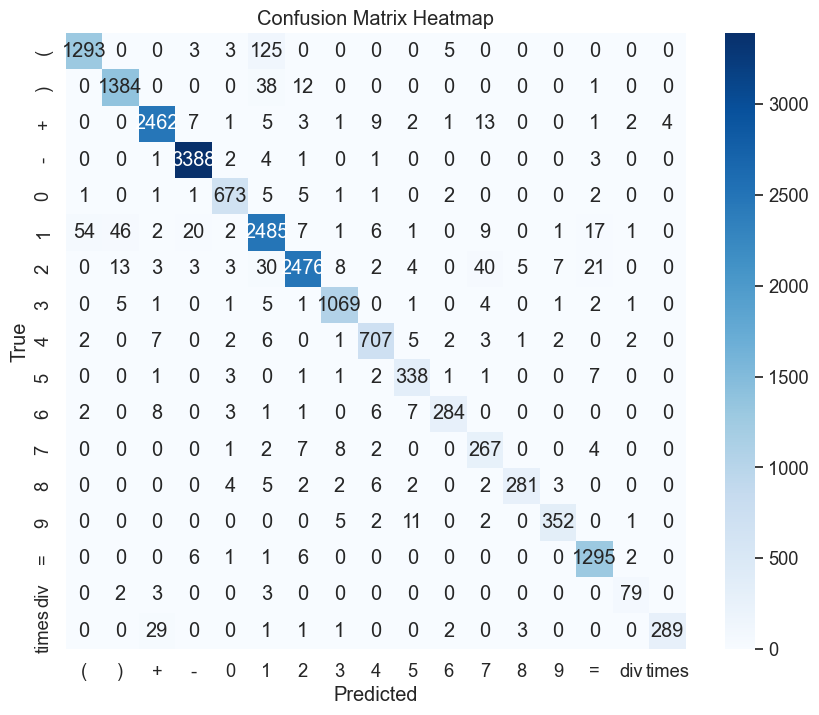

In [46]:
# to better visualize confusion matrix

# Replace this with your class labels
class_labels = [key for key, value in class_labels_dict.items() if value in np.unique(predicted_labels_test)]

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')

# Show the plot
plt.show()

In [62]:
print("Confusion Matrix Report (30 epochs)")
print(report_test)

Confusion Matrix Report (30 epochs)
Class (: Correct 1342/1429 | Wrong: 87 | %Match: 93.91
Class ): Correct 1391/1435 | Wrong: 44 | %Match: 96.93
Class +: Correct 2490/2511 | Wrong: 21 | %Match: 99.16
Class -: Correct 3387/3400 | Wrong: 13 | %Match: 99.62
Class 0: Correct 666/692 | Wrong: 26 | %Match: 96.24
Class 1: Correct 2433/2652 | Wrong: 219 | %Match: 91.74
Class 2: Correct 2547/2615 | Wrong: 68 | %Match: 97.4
Class 3: Correct 1063/1091 | Wrong: 28 | %Match: 97.43
Class 4: Correct 703/740 | Wrong: 37 | %Match: 95.0
Class 5: Correct 342/355 | Wrong: 13 | %Match: 96.34
Class 6: Correct 283/312 | Wrong: 29 | %Match: 90.71
Class 7: Correct 261/291 | Wrong: 30 | %Match: 89.69
Class 8: Correct 290/307 | Wrong: 17 | %Match: 94.46
Class 9: Correct 352/373 | Wrong: 21 | %Match: 94.37
Class =: Correct 1292/1311 | Wrong: 19 | %Match: 98.55
Class div: Correct 75/87 | Wrong: 12 | %Match: 86.21
Class times: Correct 299/326 | Wrong: 27 | %Match: 91.72



In [18]:
print("Predicted vs Actual Test")
print(predicted_report_test)

Predicted vs Actual Test
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: 1, Actual: (, Result: wrong
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: 1, Actual: (, Result: wrong
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: cor

# Running model with Unseen Test Data (from Equation Images)

In [ ]:
def pre_processing_from_test(dataset_dir):
    # Initialize lists to store images and labels
    images = []
    labels = []
    class_labels = []

    # Get a list of all subdirectories (each subdirectory represents a class)
    class_directories = os.listdir(dataset_dir)

    # Iterate through each subdirectory (class directory)
    for class_directory in class_directories:
        class_label = class_directory  # Use the directory name as the class label
        
        class_labels.append(class_label)
        class_path = os.path.join(dataset_dir, class_directory)

        # Get a list of image files in the class directory
        image_files = glob.glob(os.path.join(class_path, "*.jpg"))  # You may need to adjust the file extension

        # print(image_files)

        # Iterate through image files in the class directory
        for image_file in image_files:
            # Load and preprocess the image
            image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (28, 28))
            image = image / 255.0  # Normalize pixel values

            # plt.imshow(image, cmap=plt.cm.binary)

            # Append the preprocessed image and its label to the lists
            images.append(image)
            labels.append(class_label)

    return np.array(images), class_labels

In [ ]:
ez_test, ez_labels = pre_processing_from_test("final_82/ez")

In [ ]:
training_class_labels = ['(',')','+','-','0','1','2','3','4','5','6','7','8','9','=','div','times']

# Load the saved model
model = "digit_symbol_model_v2_with_30epochs.keras"

loaded_model = tf.keras.saving.load_model(model)

predicted_y = loaded_model.predict(ez_test)

predicted_labels = np.argmax(predicted_y, axis=1)

print("predicted_labels: ", predicted_labels)

predicted_report = ""

# Iterate through predictions and true labels to calculate correct and total instances
for i in range(predicted_labels.size):
    predicted = training_class_labels[predicted_labels[i]]
    predicted_report += predicted + " "

print("predicted output: ", predicted_report)